<h1 style="text-align: center">
Deep Learning HW4 </br>
VAE and CVAE
</h1>


### Full Name: Hesam Hosseini
### Student ID: 400101034

# Import necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision
import matplotlib.pyplot as plt

### A) what makes VQ_VAE superior than VAE

 **Discrete Latent Representations**: VQ-VAE utilizes discrete latent representations, which can lead to better generalization and interpretability compared to the continuous latent space in VAE. This is particularly beneficial for tasks where a clear understanding of the latent variables is important.

 **Efficient Memory Usage**: VQ-VAE can be more memory efficient in certain scenarios due to its use of discrete latent space, making it more scalable for handling large datasets or high-dimensional data.

  **Improved Image and Audio Generation**: VQ-VAE has shown superior performance in image and audio generation tasks compared to VAE, especially in capturing complex structures and high-frequency content. This is due in part to the use of discrete codes and the accompanying Vector Quantization loss, which can help in capturing diverse and complex patterns in the data.

  **Better Handling of Long-range Dependencies**: VQ-VAE has been reported to be better at capturing long-range dependencies in data due to its design, which can be advantageous for tasks involving sequential or hierarchical data.



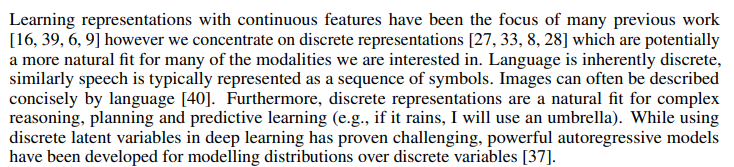

# Define the MNIST dataset and data loader

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 158779855.43it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 31827560.12it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 42024265.79it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19906508.64it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
print(f'train dataset lenght: {len(train_dataset)}')
print(f'test dataset lenght: {len(test_dataset)}')

train dataset lenght: 60000
test dataset lenght: 10000


## Data Visualization

In [ ]:
# Function to display an image
def show_image(image, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Function to show random images from each class
def show_random_images_from_each_class(dataset, num_images_per_class=4, figsize=(10, 20)):
    class_labels = list(range(10))
    fig, axs = plt.subplots(len(class_labels), num_images_per_class, figsize=figsize)

    for i, label in enumerate(class_labels):
        class_indices = [idx for idx, target in enumerate(dataset.targets) if target == label]
        random_indices = random.sample(class_indices, num_images_per_class)

        for j, idx in enumerate(random_indices):
            image, target = dataset[idx]
            axs[i, j].imshow(image[0], cmap='gray')
            axs[i, j].set_title(f"Class {label}", fontsize=16)
            axs[i, j].axis('off')
            axs[i, j].set_aspect('equal')
            axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()

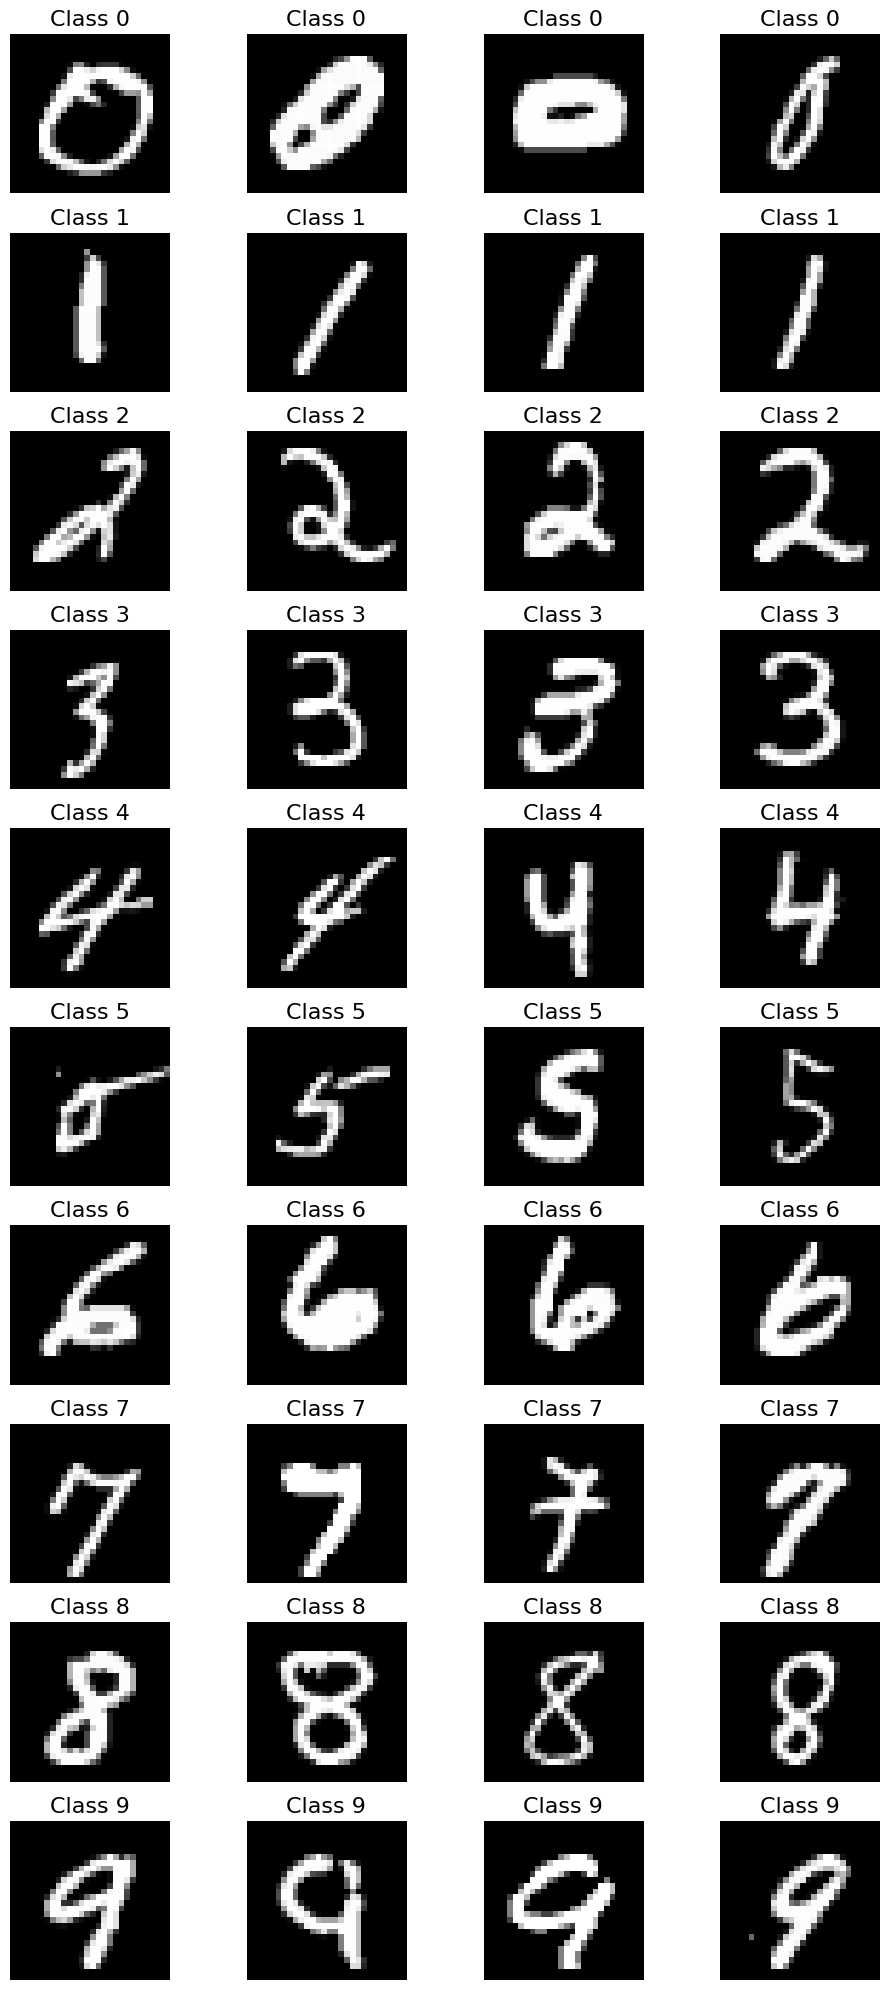

In [ ]:
# Use the function to show random images from each class
show_random_images_from_each_class(train_dataset, num_images_per_class=4)

In [5]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.8 MB/s eta 0:00:00


## model

In [6]:
import torch
import cv2
import torchvision
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from einops import rearrange
from torch.optim import Adam
#from dataset.mnist_dataset import MnistDataset
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class VQVAE(nn.Module):
    def __init__(self,input_dim=1,num_embeddings = 3, embedding_dim = 2, beta=0.2):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_dim, 16, 4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, embedding_dim*2, 4, stride=2, padding=1),
            nn.BatchNorm2d(embedding_dim*2),
            nn.ReLU(),
        )

        self.pre_quant_conv = nn.Conv2d(embedding_dim*2, embedding_dim, kernel_size=1)
        self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim)
        self.post_quant_conv = nn.Conv2d(embedding_dim, embedding_dim*2, kernel_size=1)

        # Commitment Loss Beta
        self.beta = beta

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embedding_dim*2, 16, 4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, input_dim, 4, stride=2, padding=1),
            nn.Tanh(),
        )


    def forward(self, x):
        # B, C, H, W
        encoded_output = self.encoder(x)
        quant_input = self.pre_quant_conv(encoded_output)

        ## Quantization
        B, C, H, W = quant_input.shape
        quant_input = quant_input.permute(0, 2, 3, 1)
        quant_input = quant_input.reshape((quant_input.size(0), -1, quant_input.size(-1)))

        # Compute pairwise distances
        dist = torch.cdist(quant_input, self.embedding.weight[None, :].repeat((quant_input.size(0), 1, 1)))

        # Find index of nearest embedding
        min_encoding_indices = torch.argmin(dist, dim=-1)

        # Select the embedding weights
        quant_out = torch.index_select(self.embedding.weight, 0, min_encoding_indices.view(-1))
        quant_input = quant_input.reshape((-1, quant_input.size(-1)))

        # Compute losses
        commitment_loss = torch.mean((quant_out.detach() - quant_input)**2)
        codebook_loss = torch.mean((quant_out - quant_input.detach())**2)
        quantize_losses = codebook_loss + self.beta*commitment_loss

        # Ensure straight through gradient
        quant_out = quant_input + (quant_out - quant_input).detach()

        # Reshaping back to original input shape
        quant_out = quant_out.reshape((B, H, W, C)).permute(0, 3, 1, 2)
        min_encoding_indices = min_encoding_indices.reshape((-1, quant_out.size(-2), quant_out.size(-1)))


        ## Decoder part
        decoder_input = self.post_quant_conv(quant_out)
        output = self.decoder(decoder_input)
        return output,quant_out, quantize_losses

def train_vqvae(model,mnist_loader):
    num_epochs = 10
    optimizer = Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.MSELoss()
    losses = []
    embedings = []
    for epoch_idx in range(num_epochs):
        batch_loss = 0
        for im, label in tqdm(mnist_loader):
            im = im.float().to(device)
            optimizer.zero_grad()
            out,_, quantize_loss = model(im)

            recon_loss = criterion(out, im)
            loss = recon_loss + quantize_loss
            loss.backward()
            batch_loss += loss.item()
            optimizer.step()
        embed = model.embedding
        embedding_wightes = embed.weight.cpu().detach().numpy()
        embedings.append(embedding_wightes)
        losses.append(batch_loss)
        print(f'Finished epoch {epoch_idx+1} with loss {batch_loss:.3f}')
    print('Done Training...')
    return model ,losses,embedings

In [7]:
model = VQVAE().to(device)
model,train_loss,embedings = train_vqvae(model,train_loader)

100%|██████████| 938/938 [00:13<00:00, 71.15it/s]


Finished epoch 1 with loss 163.974


100%|██████████| 938/938 [00:11<00:00, 84.79it/s]


Finished epoch 2 with loss 96.559


100%|██████████| 938/938 [00:12<00:00, 75.01it/s]


Finished epoch 3 with loss 94.867


100%|██████████| 938/938 [00:10<00:00, 86.44it/s]


Finished epoch 4 with loss 96.727


100%|██████████| 938/938 [00:11<00:00, 84.64it/s]


Finished epoch 5 with loss 100.301


100%|██████████| 938/938 [00:11<00:00, 84.49it/s]


Finished epoch 6 with loss 105.594


100%|██████████| 938/938 [00:11<00:00, 84.49it/s]


Finished epoch 7 with loss 108.068


100%|██████████| 938/938 [00:10<00:00, 89.57it/s]


Finished epoch 8 with loss 107.425


100%|██████████| 938/938 [00:10<00:00, 87.21it/s]


Finished epoch 9 with loss 104.767


100%|██████████| 938/938 [00:11<00:00, 80.75it/s]

Finished epoch 10 with loss 100.121
Done Training...


Text(0, 0.5, 'loss')

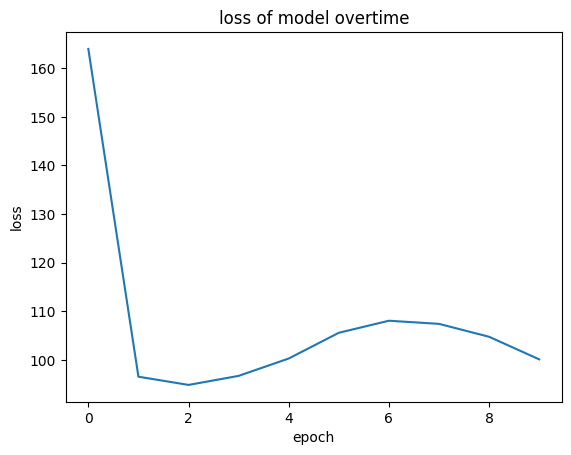

In [8]:
plt.plot(train_loss)
plt.title('loss of model overtime')
plt.xlabel('epoch')
plt.ylabel('loss')

another try:

In [ ]:
model = VQVAE().to(device)
model,train_loss,embedings = train_vqvae(model,train_loader)

100%|██████████| 938/938 [00:11<00:00, 83.28it/s]


Finished epoch 1 with loss 266.180


100%|██████████| 938/938 [00:10<00:00, 85.96it/s]


Finished epoch 2 with loss 121.664


100%|██████████| 938/938 [00:10<00:00, 86.73it/s]


Finished epoch 3 with loss 107.703


100%|██████████| 938/938 [00:11<00:00, 84.06it/s]


Finished epoch 4 with loss 117.499


100%|██████████| 938/938 [00:11<00:00, 81.75it/s]


Finished epoch 5 with loss 127.101


100%|██████████| 938/938 [00:12<00:00, 77.19it/s]


Finished epoch 6 with loss 128.110


100%|██████████| 938/938 [00:11<00:00, 82.95it/s]


Finished epoch 7 with loss 126.379


100%|██████████| 938/938 [00:11<00:00, 83.03it/s]


Finished epoch 8 with loss 124.065


100%|██████████| 938/938 [00:11<00:00, 83.32it/s]


Finished epoch 9 with loss 119.434


100%|██████████| 938/938 [00:11<00:00, 82.90it/s]

Finished epoch 10 with loss 116.382
Done Training...


## ploting loss

Text(0, 0.5, 'loss')

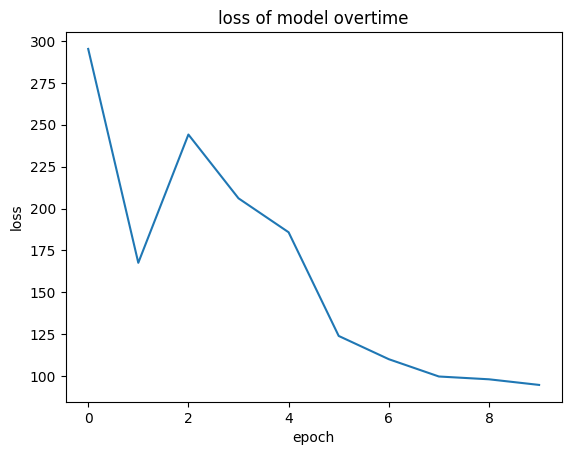

In [ ]:
plt.plot(train_loss)
plt.title('loss of model overtime')
plt.xlabel('epoch')
plt.ylabel('loss')

## some samples in,out,and code_book

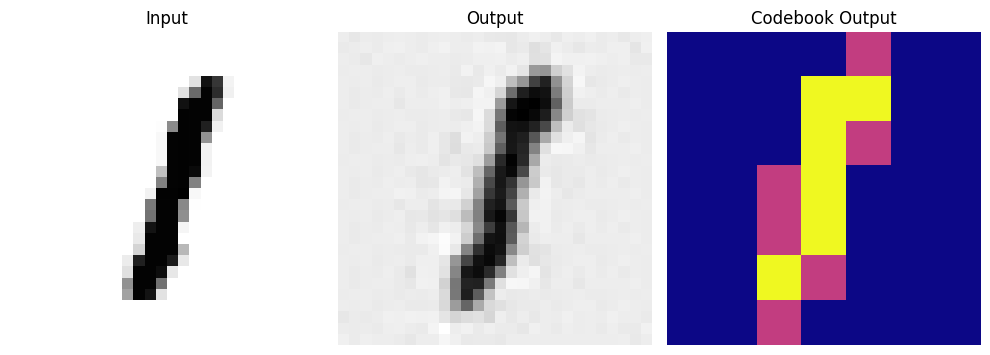

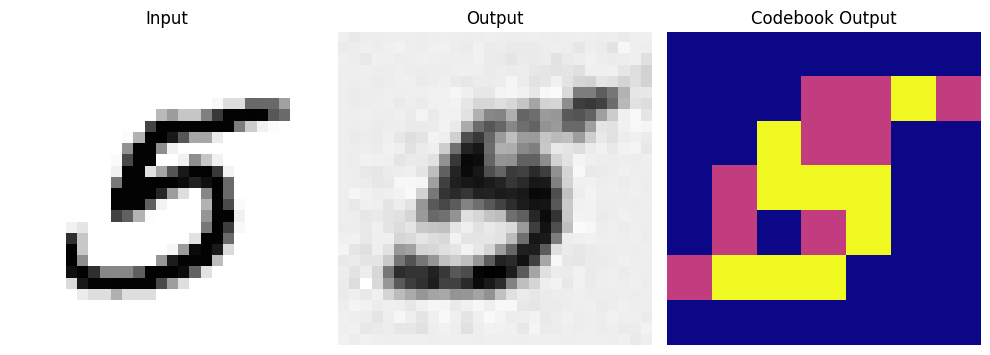

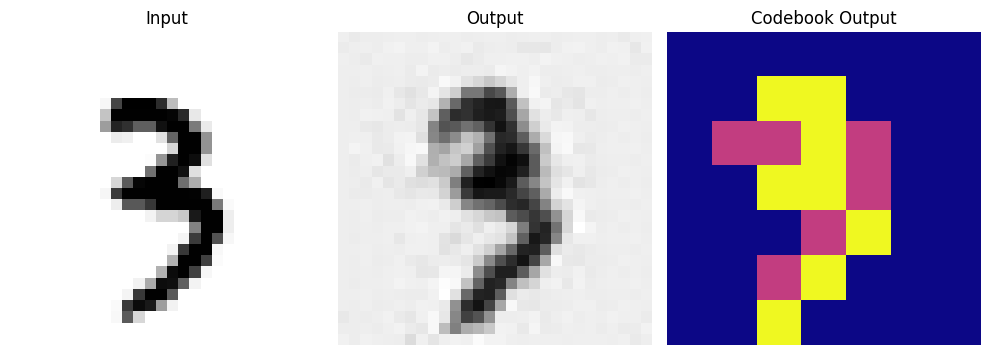

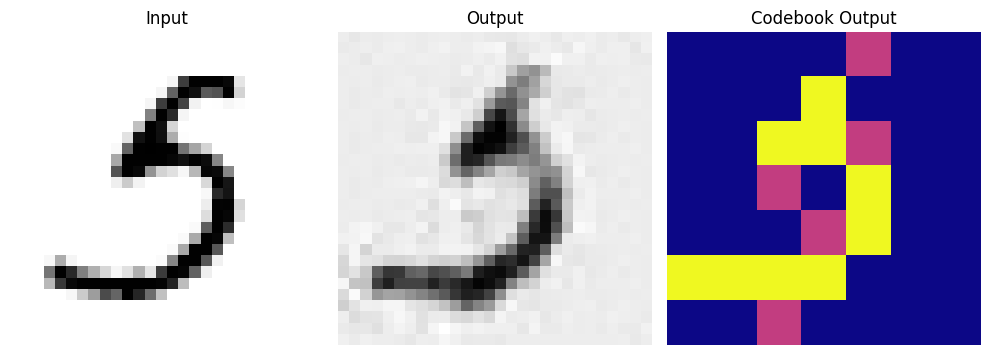

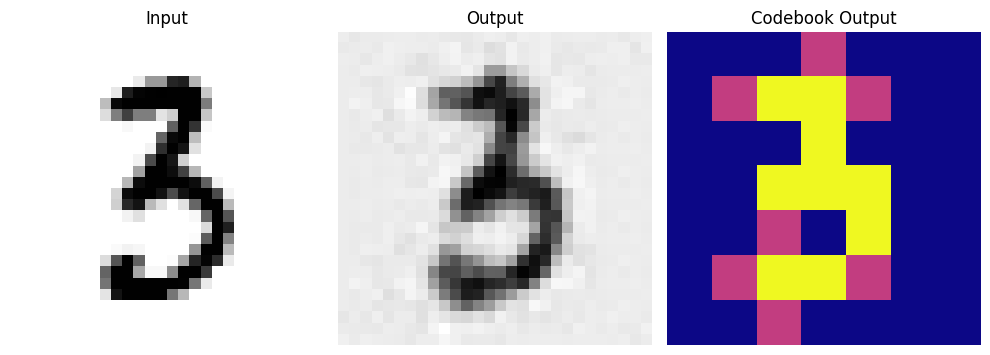

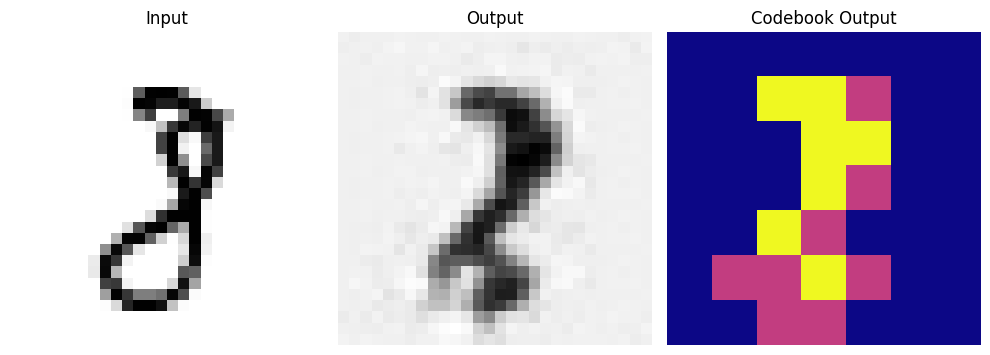

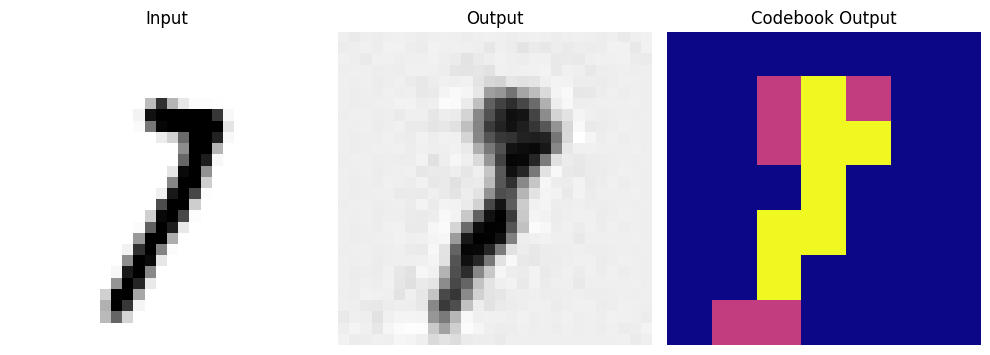

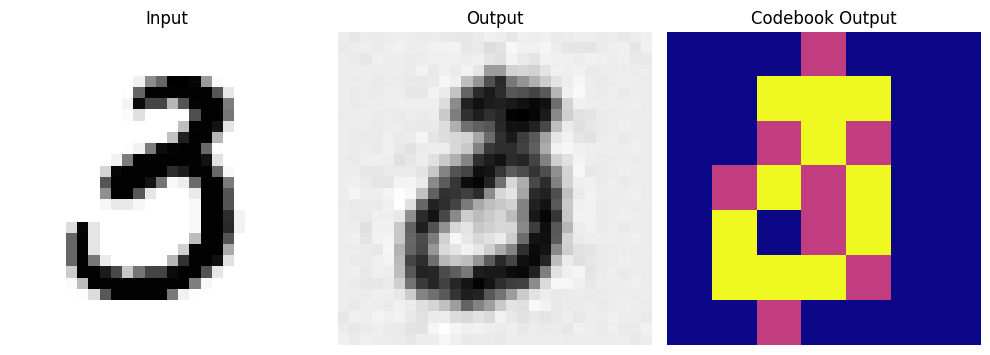

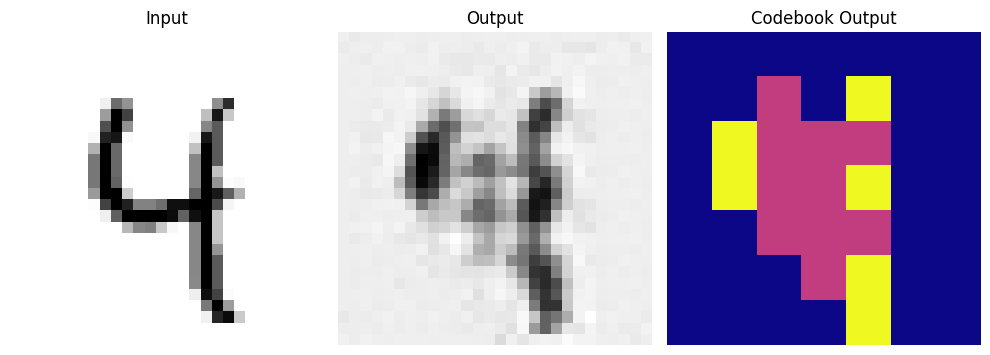

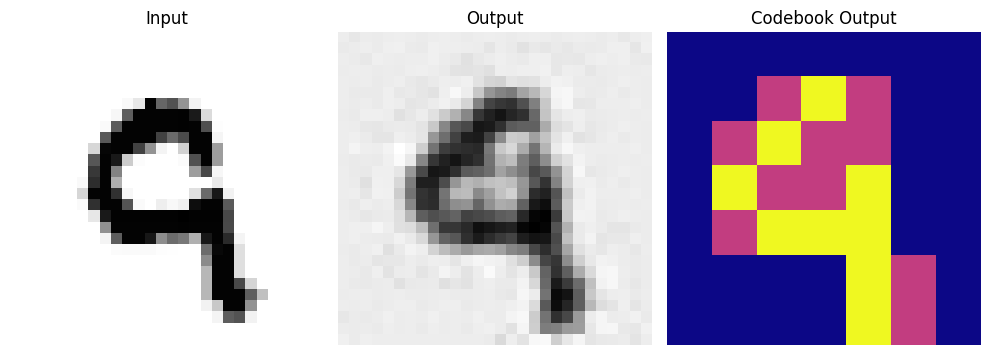

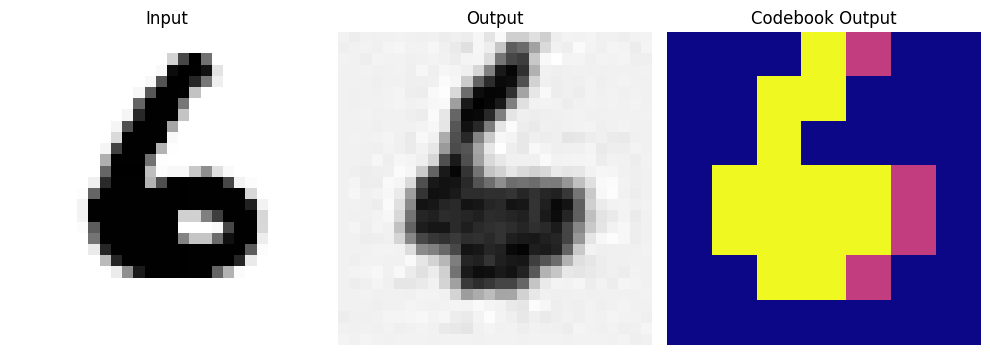

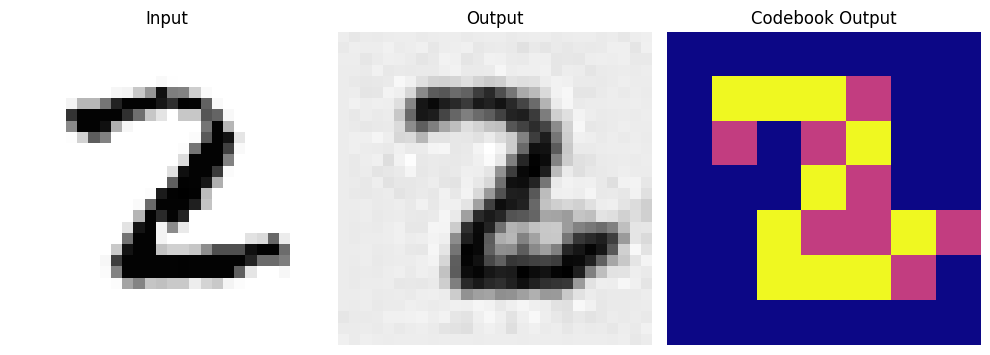

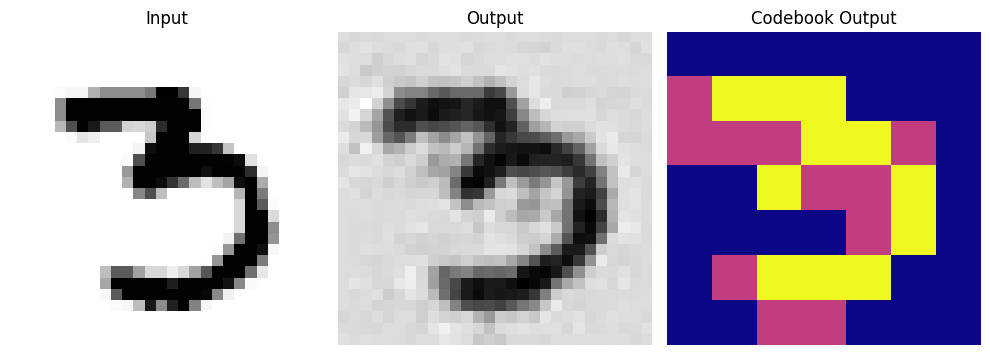

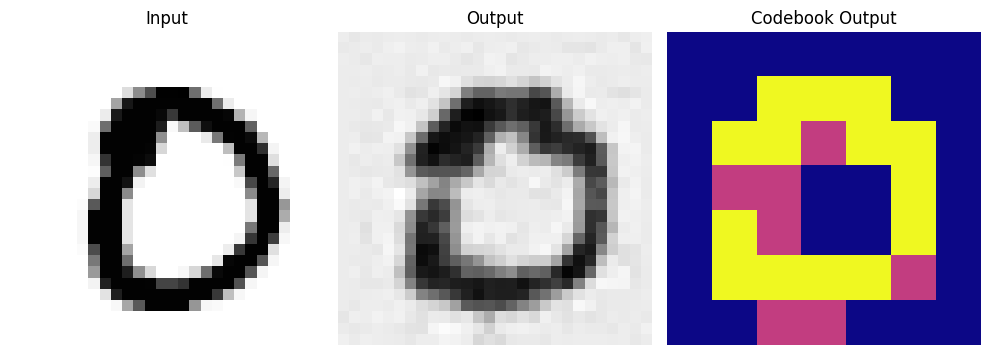

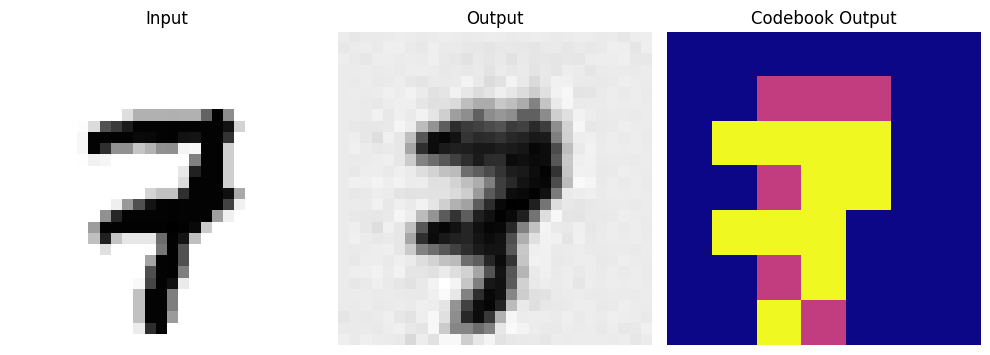

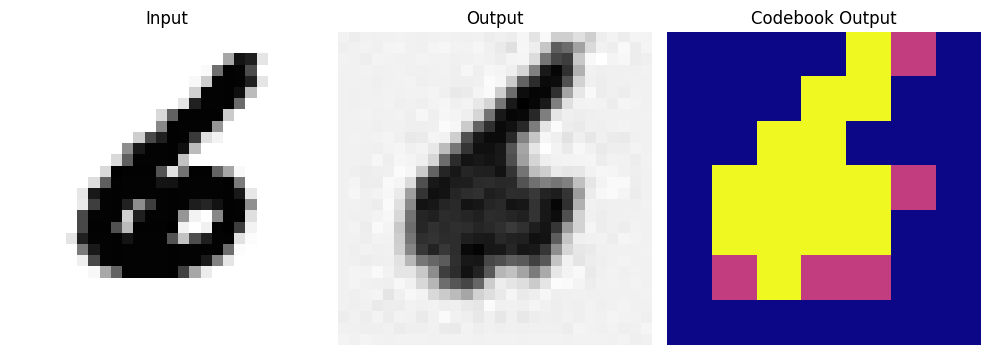

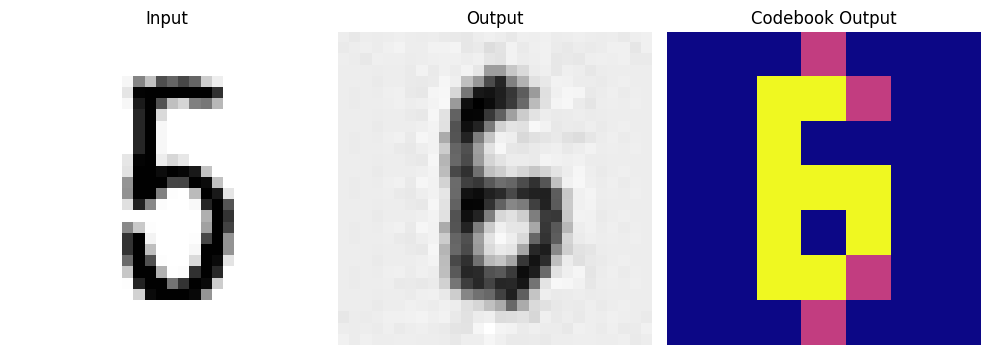

In [ ]:
def plot_output(batch,model,num=16):
  model.eval()
  batch = batch.to(device).float()
  output,quant_out, quantize_losses = model(batch)
  for i,x in enumerate(batch):
    x = x.cpu().numpy()
    out = output[i].detach().cpu().numpy()
    q_out = quant_out[i].detach().cpu().numpy()
    q_out = ((q_out[0:1, :, :]) + (q_out[1:2, :, :])) / 2
    fig,axes = plt.subplots(figsize=(10,4),ncols=3)
    axes[0].imshow(x.transpose(1, 2, 0), cmap='Greys')
    axes[0].set_title('Input')
    axes[0].axis("off")
    axes[1].imshow(out.transpose(1, 2, 0), cmap='Greys')
    axes[1].set_title('Output')
    axes[1].axis("off")
    axes[2].imshow(q_out.transpose(1, 2, 0), cmap='plasma')
    axes[2].set_title('Codebook Output')
    axes[2].axis("off")
    plt.tight_layout()
    plt.show()
    if i==num:
      break
x,y = next(iter(train_loader))
plot_output(x,model)

In [9]:
embed = model.embedding
embedding_wightes = embed.weight.cpu().detach().numpy()
embedding_wightes.shape

(3, 2)

(-2.0, 2.0)

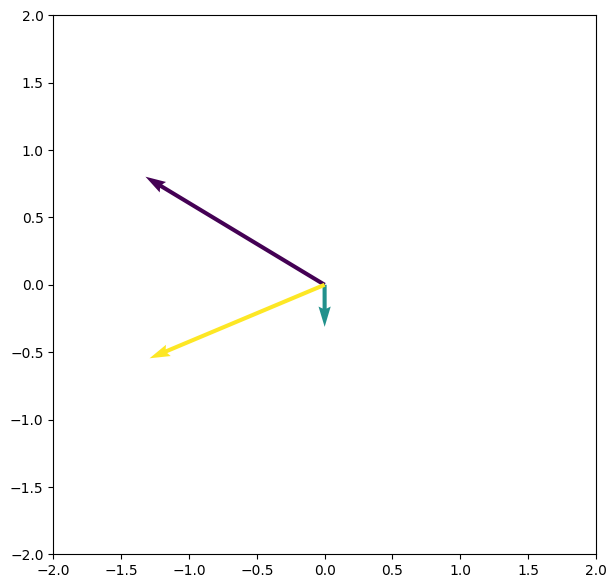

In [10]:
fig, ax = plt.subplots(figsize=(7, 7))
colors = plt.cm.viridis(np.linspace(0, 1, len(embedding_wightes)))
ax.clear()  # Clearing the axes for the new frame
ax.quiver(np.zeros(3), np.zeros(3),
          embedding_wightes[:, 0],
          embedding_wightes[:, 1],
          angles='xy', scale_units='xy', scale=1, color=colors)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

#plt.scatter(embedding_wightes[:,0],embedding_wightes[:,1])

### genrating animation

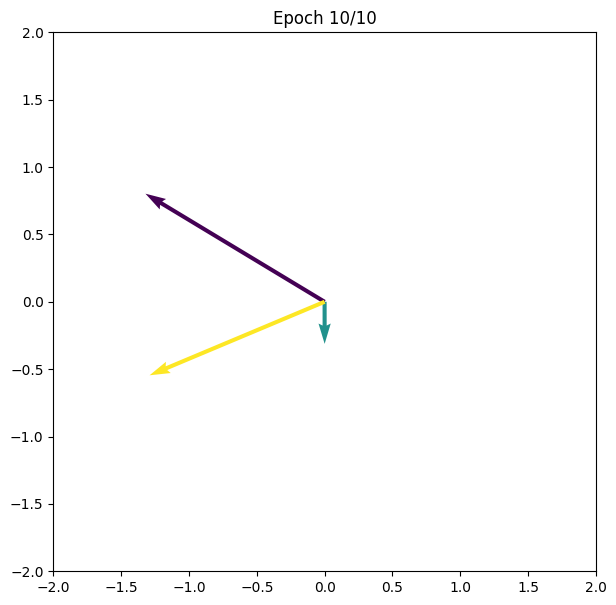

In [12]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(7, 7))
colors = plt.cm.viridis(np.linspace(0, 1, len(embedding_wightes)))

def update(frame):
    ax.clear()
    ax.quiver(np.zeros(3), np.zeros(3),embedings[frame][:, 0],embedings[frame][:, 1],angles='xy', scale_units='xy', scale=1, color=colors)
    ax.set_title(f'Epoch {frame + 1}/{10}')
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)

ani = FuncAnimation(fig, update, frames=len(embedings), repeat=False)
ani.save('codebook_embeding_vectors.gif', writer='imagemagick', fps=8)
plt.show()

## some samples

Done Reconstruction ...


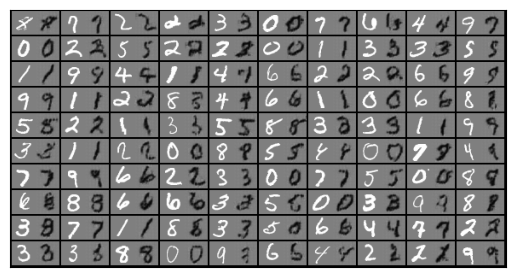

In [ ]:
idxs = torch.randint(0, len(test_dataset), (100, ))
ims = torch.cat([test_dataset[idx][0][None, :] for idx in idxs]).float()
ims = ims.to(device)
model.eval()


generated_im, _ = model(ims)
ims = (ims+1)/2
generated_im = 1 - (generated_im+1)/2
out = torch.hstack([ims, generated_im])
output = rearrange(out, 'b c h w -> b () h (c w)')
grid = torchvision.utils.make_grid(output.detach().cpu(), nrow=10)
img = torchvision.transforms.ToPILImage()(grid)

fig = plt.imshow(img)
fig.set_cmap('hot')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
img.save('reconstruction.png')

print('Done Reconstruction ...')

## colored dataset

In [ ]:
class Coloured_Dataset(Dataset):
    def __init__(self, root, train=True, transform=None, download=True, random_seed=42):
        self.mnist_dataset = datasets.MNIST(root=root, train=train, transform=transform, download=download)
        self.random_seed = random_seed # for reproducibility
        self.random_state = torch.manual_seed(self.random_seed)
    def __len__(self):
        return len(self.mnist_dataset)
    def __getitem__(self, idx):
        torch.manual_seed(self.random_seed * idx)
        data, target = self.mnist_dataset[idx]
        Coloured = data.repeat( 3, 1, 1)
        Coloured[0] *= torch.rand(1)
        Coloured[1] *= torch.rand(1)
        Coloured[2] *= torch.rand(1)
        return Coloured, target

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
coloured_dataset = Coloured_Dataset(root='./data', train=True, transform=transform, download=True)
coloured_dataset_test = Coloured_Dataset(root='./data', train=False, transform=transform, download=True)
coloured_loader_test = DataLoader(coloured_dataset_test, batch_size=1, shuffle=True)

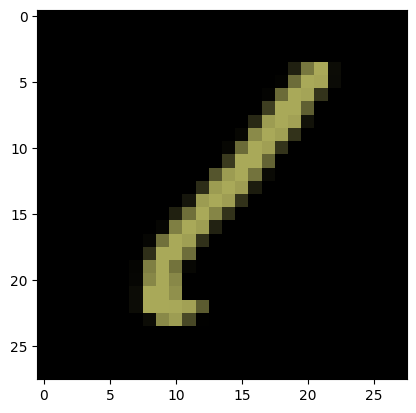

In [ ]:
coloured_loader = DataLoader(coloured_dataset, batch_size=64, shuffle=True)
x,y = next(iter(coloured_loader))
x = x[0]
plt.imshow(x.cpu().numpy().transpose(1, 2, 0))

### changing number of embedings

In [ ]:
import numpy as np
num_embeds = [3,10,20,30,40,50]
loss = []
models = []
all_embeds = []
for num in num_embeds:
  model = VQVAE(input_dim=3,num_embeddings=num).to(device)
  print('-------------')
  print(f'training with {num} number of embeding vectors')
  model,train_loss,embedings = train_vqvae(model,coloured_loader)

  loss.append(train_loss)
  models.append(model)
  all_embeds.append(embedings)

-------------
training with 3 number of embeding vectors


100%|██████████| 938/938 [00:29<00:00, 31.36it/s]


Finished epoch 1 with loss 150.299


100%|██████████| 938/938 [00:23<00:00, 40.20it/s]


Finished epoch 2 with loss 58.785


100%|██████████| 938/938 [00:19<00:00, 47.92it/s]


Finished epoch 3 with loss 39.347


100%|██████████| 938/938 [00:19<00:00, 47.85it/s]


Finished epoch 4 with loss 33.771


100%|██████████| 938/938 [00:20<00:00, 46.31it/s]


Finished epoch 5 with loss 30.005


100%|██████████| 938/938 [00:23<00:00, 39.37it/s]


Finished epoch 6 with loss 28.094


100%|██████████| 938/938 [00:20<00:00, 44.77it/s]


Finished epoch 7 with loss 26.761


100%|██████████| 938/938 [00:21<00:00, 43.17it/s]


Finished epoch 8 with loss 26.010


100%|██████████| 938/938 [00:21<00:00, 43.14it/s]


Finished epoch 9 with loss 25.835


100%|██████████| 938/938 [00:19<00:00, 46.94it/s]


Finished epoch 10 with loss 26.048
Done Training...
-------------
training with 10 number of embeding vectors


100%|██████████| 938/938 [00:19<00:00, 47.85it/s]


Finished epoch 1 with loss 50.718


100%|██████████| 938/938 [00:19<00:00, 47.32it/s]


Finished epoch 2 with loss 25.177


100%|██████████| 938/938 [00:19<00:00, 47.78it/s]


Finished epoch 3 with loss 23.970


100%|██████████| 938/938 [00:19<00:00, 49.08it/s]


Finished epoch 4 with loss 24.015


100%|██████████| 938/938 [00:20<00:00, 46.62it/s]


Finished epoch 5 with loss 24.219


100%|██████████| 938/938 [00:19<00:00, 48.85it/s]


Finished epoch 6 with loss 24.464


100%|██████████| 938/938 [00:20<00:00, 46.78it/s]


Finished epoch 7 with loss 24.590


100%|██████████| 938/938 [00:19<00:00, 48.91it/s]


Finished epoch 8 with loss 24.777


100%|██████████| 938/938 [00:20<00:00, 46.76it/s]


Finished epoch 9 with loss 24.951


100%|██████████| 938/938 [00:19<00:00, 49.18it/s]


Finished epoch 10 with loss 25.051
Done Training...
-------------
training with 20 number of embeding vectors


100%|██████████| 938/938 [00:22<00:00, 41.17it/s]


Finished epoch 1 with loss 82.548


100%|██████████| 938/938 [00:28<00:00, 33.19it/s]


Finished epoch 2 with loss 30.518


100%|██████████| 938/938 [00:19<00:00, 46.96it/s]


Finished epoch 3 with loss 25.676


100%|██████████| 938/938 [00:19<00:00, 48.88it/s]


Finished epoch 4 with loss 24.411


100%|██████████| 938/938 [00:19<00:00, 47.24it/s]


Finished epoch 5 with loss 23.029


100%|██████████| 938/938 [00:19<00:00, 48.98it/s]


Finished epoch 6 with loss 21.694


100%|██████████| 938/938 [00:19<00:00, 47.01it/s]


Finished epoch 7 with loss 20.635


100%|██████████| 938/938 [00:19<00:00, 48.65it/s]


Finished epoch 8 with loss 19.881


100%|██████████| 938/938 [00:19<00:00, 47.02it/s]


Finished epoch 9 with loss 19.303


100%|██████████| 938/938 [00:19<00:00, 48.35it/s]


Finished epoch 10 with loss 18.920
Done Training...
-------------
training with 30 number of embeding vectors


100%|██████████| 938/938 [00:23<00:00, 40.50it/s]


Finished epoch 1 with loss 60.523


100%|██████████| 938/938 [00:22<00:00, 41.81it/s]


Finished epoch 2 with loss 24.074


100%|██████████| 938/938 [00:18<00:00, 49.62it/s]


Finished epoch 3 with loss 20.965


100%|██████████| 938/938 [00:20<00:00, 46.12it/s]


Finished epoch 4 with loss 19.130


100%|██████████| 938/938 [00:20<00:00, 46.67it/s]


Finished epoch 5 with loss 17.748


100%|██████████| 938/938 [00:20<00:00, 46.23it/s]


Finished epoch 6 with loss 16.746


100%|██████████| 938/938 [00:19<00:00, 47.08it/s]


Finished epoch 7 with loss 16.139


100%|██████████| 938/938 [00:19<00:00, 48.71it/s]


Finished epoch 8 with loss 15.722


100%|██████████| 938/938 [00:19<00:00, 47.07it/s]


Finished epoch 9 with loss 15.408


100%|██████████| 938/938 [00:19<00:00, 49.05it/s]


Finished epoch 10 with loss 15.149
Done Training...
-------------
training with 40 number of embeding vectors


100%|██████████| 938/938 [00:20<00:00, 46.76it/s]


Finished epoch 1 with loss 50.402


100%|██████████| 938/938 [00:19<00:00, 48.51it/s]


Finished epoch 2 with loss 20.488


100%|██████████| 938/938 [00:20<00:00, 46.49it/s]


Finished epoch 3 with loss 17.074


100%|██████████| 938/938 [00:19<00:00, 48.96it/s]


Finished epoch 4 with loss 16.129


100%|██████████| 938/938 [00:19<00:00, 47.56it/s]


Finished epoch 5 with loss 16.542


100%|██████████| 938/938 [00:19<00:00, 48.15it/s]


Finished epoch 6 with loss 17.005


100%|██████████| 938/938 [00:19<00:00, 47.81it/s]


Finished epoch 7 with loss 17.207


100%|██████████| 938/938 [00:19<00:00, 48.24it/s]


Finished epoch 8 with loss 17.571


100%|██████████| 938/938 [00:19<00:00, 47.80it/s]


Finished epoch 9 with loss 17.272


100%|██████████| 938/938 [00:19<00:00, 47.55it/s]


Finished epoch 10 with loss 16.927
Done Training...
-------------
training with 50 number of embeding vectors


100%|██████████| 938/938 [00:19<00:00, 48.31it/s]


Finished epoch 1 with loss 48.331


100%|██████████| 938/938 [00:19<00:00, 47.73it/s]


Finished epoch 2 with loss 19.334


100%|██████████| 938/938 [00:19<00:00, 48.66it/s]


Finished epoch 3 with loss 17.439


100%|██████████| 938/938 [00:20<00:00, 45.19it/s]


Finished epoch 4 with loss 16.262


100%|██████████| 938/938 [00:19<00:00, 48.90it/s]


Finished epoch 5 with loss 15.413


100%|██████████| 938/938 [00:19<00:00, 47.00it/s]


Finished epoch 6 with loss 14.925


100%|██████████| 938/938 [00:19<00:00, 48.19it/s]


Finished epoch 7 with loss 14.639


100%|██████████| 938/938 [00:19<00:00, 47.02it/s]


Finished epoch 8 with loss 14.572


100%|██████████| 938/938 [00:19<00:00, 48.49it/s]


Finished epoch 9 with loss 14.509


100%|██████████| 938/938 [00:20<00:00, 46.72it/s]

Finished epoch 10 with loss 14.360
Done Training...


Text(0.5, 0, 'Epoch')

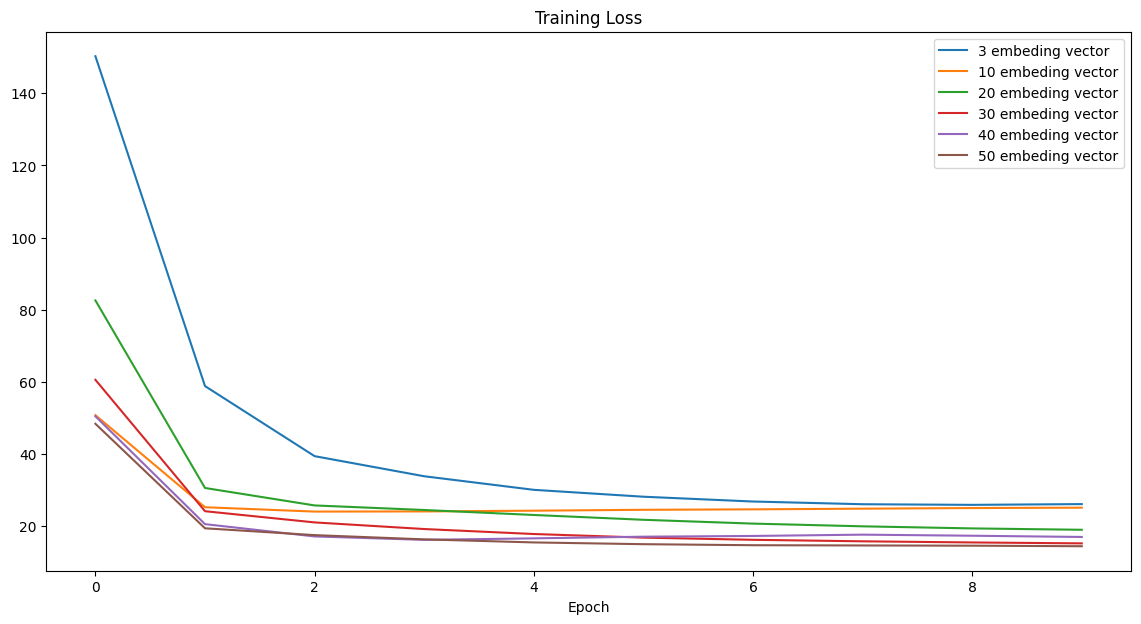

In [ ]:
plt.figure(figsize=(14, 7))
legends = []
for i, train_loss in enumerate(loss):
  plt.plot(train_loss)
  legends.append(f'{num_embeds[i]} embeding vector')
plt.legend(legends)
plt.title('Training Loss')
plt.xlabel('Epoch')

In [ ]:
x,y = next(iter(coloured_loader_test))

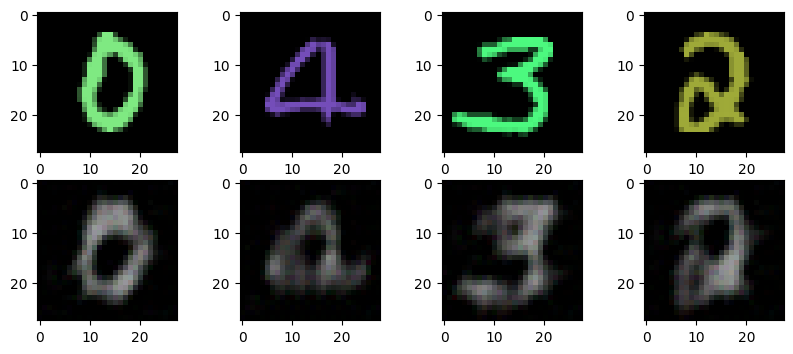

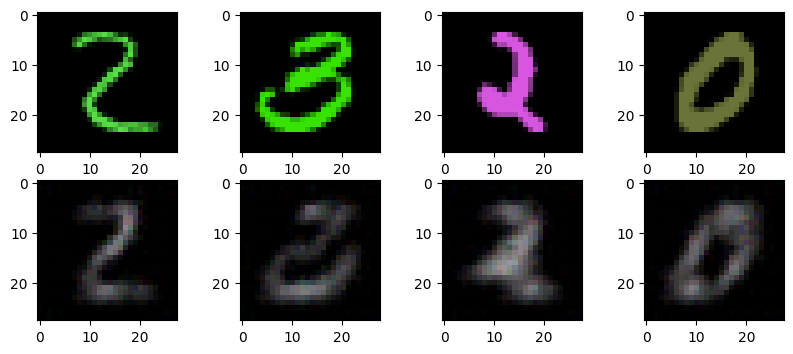

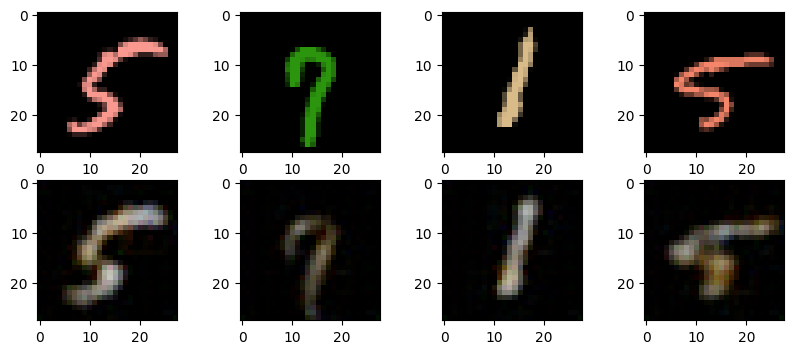

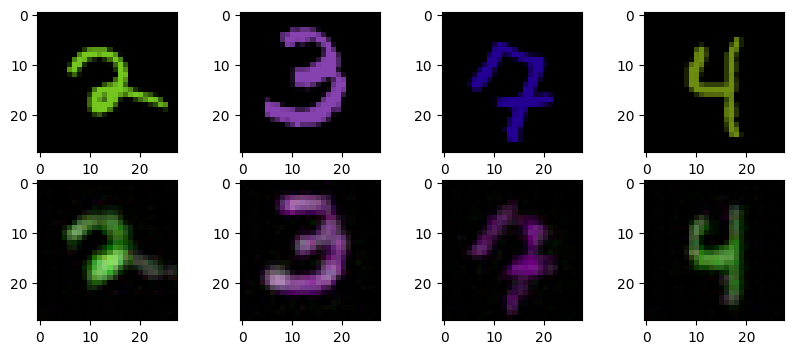

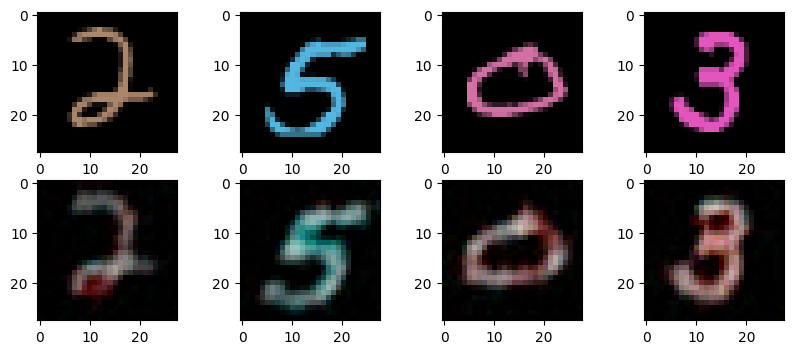

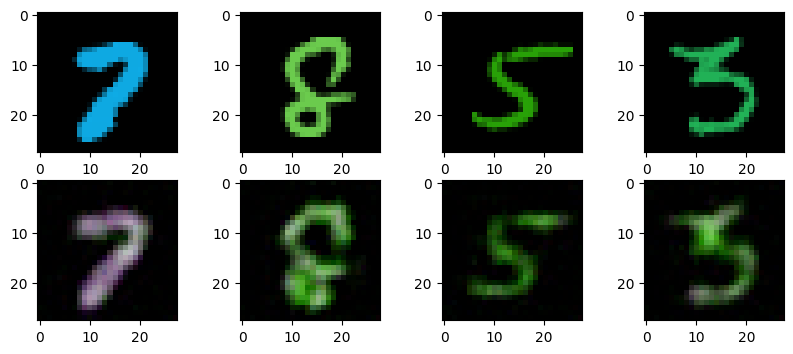

In [ ]:
for i,model in enumerate(models):
  j = 0
  fig , axes = plt.subplots(figsize=(10,4),ncols=4,nrows=2)
  for x,y in (coloured_loader_test):
    if j == 4 :
      break
    output,quant_out, quantize_losses = model(x.to(device).float())
    x = x[0].cpu().numpy()
    out = output[0].detach().cpu().numpy()
    axes[0,j].imshow(x.transpose(1, 2, 0))
    axes[1,j].imshow(out.transpose(1, 2, 0))
    j+=1
  plt.show()

as you can see the model performase becomes better by incresing the number of embeding codebooks and it starts giving colored output 

that is becuase we can learn diffrent structures of data our qountizition error becomes less

### changing dimention of embedings

In [ ]:
import numpy as np
dim_embeds = [3,10,20,30,40,50]
loss = []
models = []
all_embeds = []
for num in dim_embeds:
  model = VQVAE(input_dim=3,embedding_dim=num).to(device)
  print('-------------')
  print(f'training with  dimention {num} of embeding vectors')
  model,train_loss,embedings = train_vqvae(model,coloured_loader)

  loss.append(train_loss)
  models.append(model)
  all_embeds.append(embedings)

-------------
training with 3 number of embeding vectors


100%|██████████| 938/938 [00:20<00:00, 44.74it/s]


Finished epoch 1 with loss 107.976


100%|██████████| 938/938 [00:22<00:00, 41.98it/s]


Finished epoch 2 with loss 52.354


100%|██████████| 938/938 [00:20<00:00, 46.28it/s]


Finished epoch 3 with loss 57.029


100%|██████████| 938/938 [00:22<00:00, 41.93it/s]


Finished epoch 4 with loss 60.148


100%|██████████| 938/938 [00:19<00:00, 47.01it/s]


Finished epoch 5 with loss 60.071


100%|██████████| 938/938 [00:20<00:00, 45.90it/s]


Finished epoch 6 with loss 59.915


100%|██████████| 938/938 [00:19<00:00, 47.22it/s]


Finished epoch 7 with loss 62.961


100%|██████████| 938/938 [00:20<00:00, 46.03it/s]


Finished epoch 8 with loss 64.678


100%|██████████| 938/938 [00:19<00:00, 47.63it/s]


Finished epoch 9 with loss 66.795


100%|██████████| 938/938 [00:20<00:00, 45.60it/s]


Finished epoch 10 with loss 69.660
Done Training...
-------------
training with 10 number of embeding vectors


100%|██████████| 938/938 [00:20<00:00, 46.54it/s]


Finished epoch 1 with loss 406.034


100%|██████████| 938/938 [00:19<00:00, 47.24it/s]


Finished epoch 2 with loss 93.594


100%|██████████| 938/938 [00:20<00:00, 46.10it/s]


Finished epoch 3 with loss 63.069


100%|██████████| 938/938 [00:19<00:00, 47.56it/s]


Finished epoch 4 with loss 59.086


100%|██████████| 938/938 [00:20<00:00, 45.88it/s]


Finished epoch 5 with loss 58.991


100%|██████████| 938/938 [00:19<00:00, 47.24it/s]


Finished epoch 6 with loss 59.644


100%|██████████| 938/938 [00:20<00:00, 45.87it/s]


Finished epoch 7 with loss 60.159


100%|██████████| 938/938 [00:19<00:00, 47.50it/s]


Finished epoch 8 with loss 60.954


100%|██████████| 938/938 [00:20<00:00, 45.87it/s]


Finished epoch 9 with loss 61.699


100%|██████████| 938/938 [00:20<00:00, 46.21it/s]


Finished epoch 10 with loss 62.749
Done Training...
-------------
training with 20 number of embeding vectors


100%|██████████| 938/938 [00:20<00:00, 45.40it/s]


Finished epoch 1 with loss 345.021


100%|██████████| 938/938 [00:21<00:00, 43.28it/s]


Finished epoch 2 with loss 81.932


100%|██████████| 938/938 [00:20<00:00, 45.03it/s]


Finished epoch 3 with loss 82.083


100%|██████████| 938/938 [00:21<00:00, 44.30it/s]


Finished epoch 4 with loss 87.214


100%|██████████| 938/938 [00:21<00:00, 42.96it/s]


Finished epoch 5 with loss 89.020


100%|██████████| 938/938 [00:20<00:00, 45.28it/s]


Finished epoch 6 with loss 88.869


100%|██████████| 938/938 [00:22<00:00, 42.59it/s]


Finished epoch 7 with loss 88.007


100%|██████████| 938/938 [00:20<00:00, 45.71it/s]


Finished epoch 8 with loss 87.789


100%|██████████| 938/938 [00:21<00:00, 44.28it/s]


Finished epoch 9 with loss 87.408


100%|██████████| 938/938 [00:21<00:00, 43.69it/s]


Finished epoch 10 with loss 87.247
Done Training...
-------------
training with 30 number of embeding vectors


100%|██████████| 938/938 [00:20<00:00, 46.78it/s]


Finished epoch 1 with loss 256.573


100%|██████████| 938/938 [00:21<00:00, 43.22it/s]


Finished epoch 2 with loss 94.304


100%|██████████| 938/938 [00:20<00:00, 44.86it/s]


Finished epoch 3 with loss 97.349


100%|██████████| 938/938 [00:21<00:00, 44.37it/s]


Finished epoch 4 with loss 97.927


100%|██████████| 938/938 [00:20<00:00, 44.83it/s]


Finished epoch 5 with loss 96.702


100%|██████████| 938/938 [00:20<00:00, 45.79it/s]


Finished epoch 6 with loss 93.900


100%|██████████| 938/938 [00:21<00:00, 43.60it/s]


Finished epoch 7 with loss 90.694


100%|██████████| 938/938 [00:21<00:00, 43.68it/s]


Finished epoch 8 with loss 89.463


100%|██████████| 938/938 [00:20<00:00, 45.61it/s]


Finished epoch 9 with loss 88.669


100%|██████████| 938/938 [00:21<00:00, 43.17it/s]


Finished epoch 10 with loss 87.513
Done Training...
-------------
training with 40 number of embeding vectors


100%|██████████| 938/938 [00:20<00:00, 45.64it/s]


Finished epoch 1 with loss 601.347


100%|██████████| 938/938 [00:20<00:00, 45.96it/s]


Finished epoch 2 with loss 604.292


100%|██████████| 938/938 [00:20<00:00, 45.53it/s]


Finished epoch 3 with loss 621.945


100%|██████████| 938/938 [00:19<00:00, 47.65it/s]


Finished epoch 4 with loss 573.639


100%|██████████| 938/938 [00:20<00:00, 45.73it/s]


Finished epoch 5 with loss 516.975


100%|██████████| 938/938 [00:19<00:00, 47.13it/s]


Finished epoch 6 with loss 463.808


100%|██████████| 938/938 [00:20<00:00, 45.82it/s]


Finished epoch 7 with loss 416.676


100%|██████████| 938/938 [00:20<00:00, 45.49it/s]


Finished epoch 8 with loss 377.783


100%|██████████| 938/938 [00:26<00:00, 35.38it/s]


Finished epoch 9 with loss 343.146


100%|██████████| 938/938 [00:20<00:00, 46.13it/s]


Finished epoch 10 with loss 313.615
Done Training...
-------------
training with 50 number of embeding vectors


100%|██████████| 938/938 [00:20<00:00, 45.31it/s]


Finished epoch 1 with loss 441.558


100%|██████████| 938/938 [00:19<00:00, 47.03it/s]


Finished epoch 2 with loss 520.210


100%|██████████| 938/938 [00:20<00:00, 45.04it/s]


Finished epoch 3 with loss 524.276


100%|██████████| 938/938 [00:20<00:00, 46.02it/s]


Finished epoch 4 with loss 482.450


100%|██████████| 938/938 [00:20<00:00, 45.59it/s]


Finished epoch 5 with loss 424.383


100%|██████████| 938/938 [00:20<00:00, 45.19it/s]


Finished epoch 6 with loss 351.624


100%|██████████| 938/938 [00:20<00:00, 46.67it/s]


Finished epoch 7 with loss 299.644


100%|██████████| 938/938 [00:20<00:00, 45.04it/s]


Finished epoch 8 with loss 261.460


100%|██████████| 938/938 [00:20<00:00, 45.83it/s]


Finished epoch 9 with loss 229.785


100%|██████████| 938/938 [00:20<00:00, 44.85it/s]

Finished epoch 10 with loss 206.791
Done Training...


Text(0.5, 0, 'Epoch')

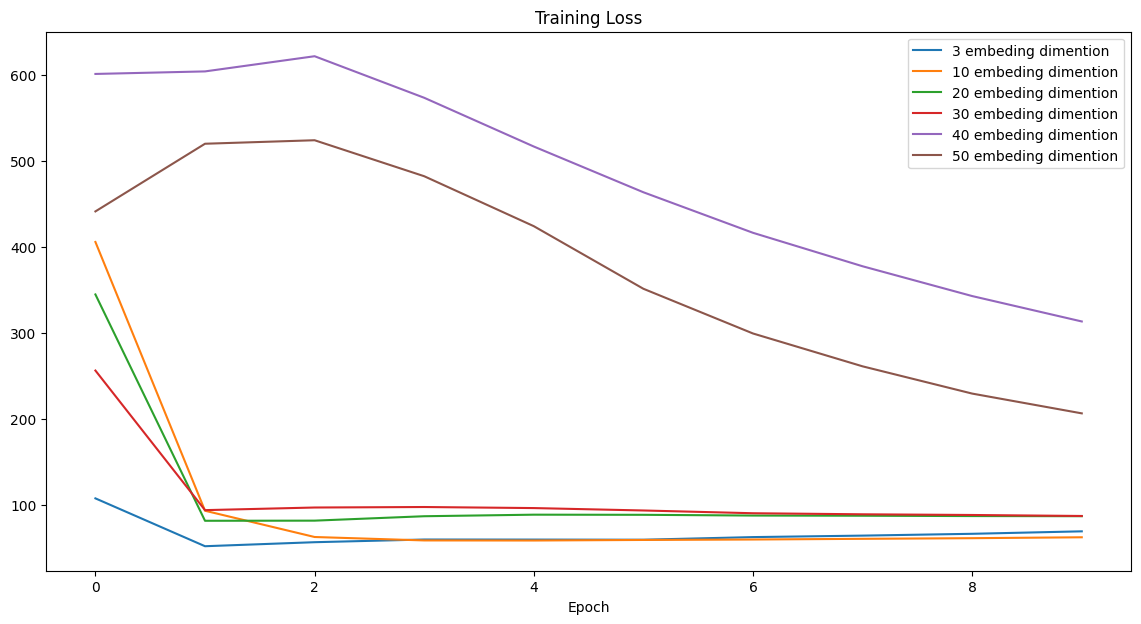

In [ ]:
plt.figure(figsize=(14, 7))
legends = []
for i, train_loss in enumerate(loss):
  plt.plot(train_loss)
  legends.append(f'{dim_embeds[i]} embeding dimention')
plt.legend(legends)
plt.title('Training Loss')
plt.xlabel('Epoch')

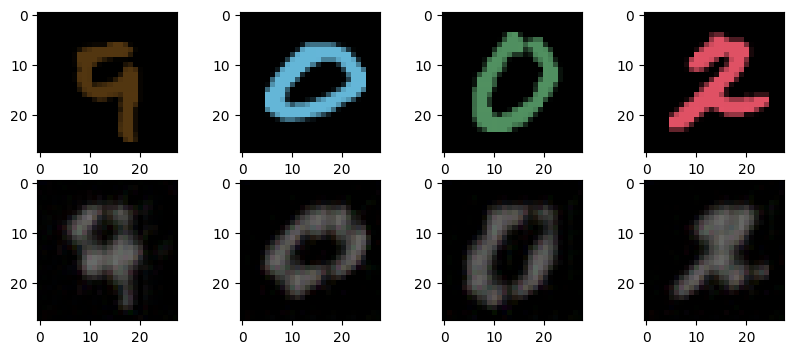

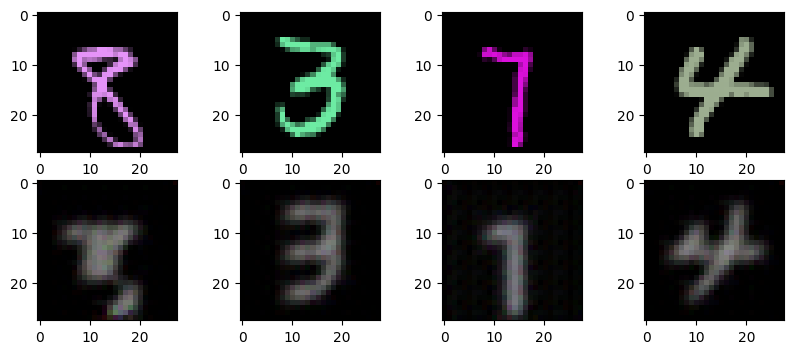

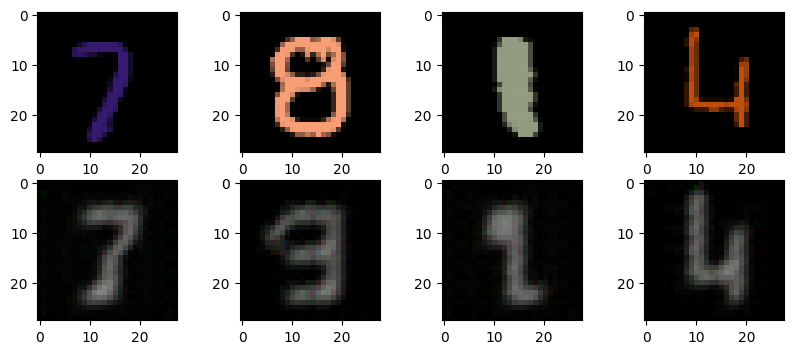

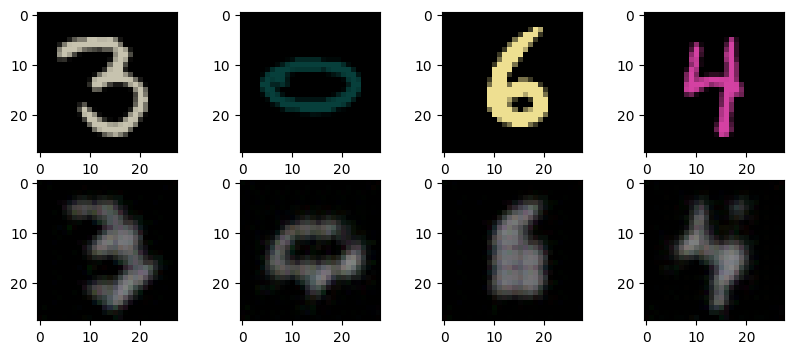

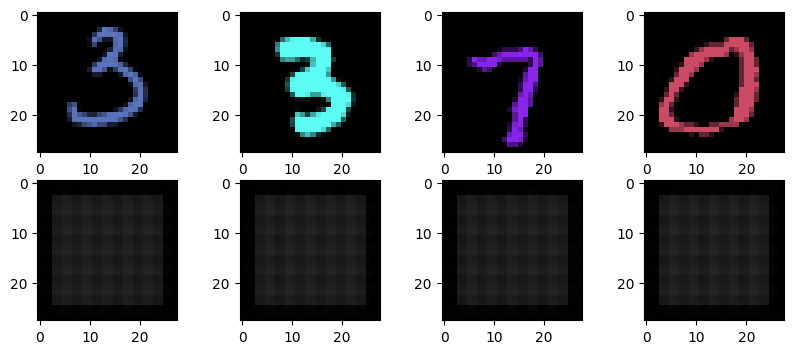

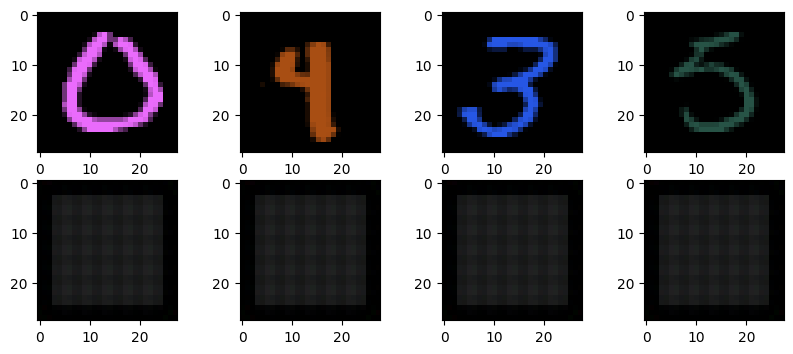

In [ ]:
for i,model in enumerate(models):
  j = 0
  fig , axes = plt.subplots(figsize=(10,4),ncols=4,nrows=2)
  for x,y in (coloured_loader_test):
    if j == 4 :
      break
    output,quant_out, quantize_losses = model(x.to(device).float())
    x = x[0].cpu().numpy()
    out = output[0].detach().cpu().numpy()
    axes[0,j].imshow(x.transpose(1, 2, 0))
    axes[1,j].imshow(out.transpose(1, 2, 0))
    j+=1
  plt.show()

as you can see the model performace becomes worst by incresing the dimention of embeding codebooks until it givees meaningless output 

that is becuase we need more training epochs to converge for a larger embeding dimention 

even at the begining we couldnt produce colored data beacuse of the fact that the number of embeding vector is small (we already disscused it in the previous section)